In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler

c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if a GPU available
# if GPU is not available, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Function to get the total number of lines in the file
def get_total_lines(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)

# Function to load rows where 'stars' feature is 1.0 or 2.0
def load_selected_data_0(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [1.0, 2.0]:  
                data.append(row)
                count += 1
                if count == 5000:  
                    break
    return data

# Function to load rows where 'stars' feature is 3.0
def load_selected_data_1(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') == 3.0:
                data.append(row)
                count += 1
                if count == 5000:  
                    break
    return data

# Function to load rows where 'stars' feature is 4.0 or 5.0
def load_selected_data_2(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [4.0, 5.0]:  
                data.append(row)
                count += 1
                if count == 5000:  
                    break
    return data

# File path
file_path = 'yelp_academic_dataset_review.json'

# Load the data
yelp_data_0 = pd.DataFrame(load_selected_data_0(file_path))
yelp_data_1 = pd.DataFrame(load_selected_data_1(file_path))
yelp_data_2 = pd.DataFrame(load_selected_data_2(file_path))

In [4]:
#load the dataframe
yelp_data_0.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
2,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
3,Ki90-hauSIfW_7sBuBBqfA,Z2cOL3n9V8NoguJ-uU_Nvw,j8JOZvfeHEfUWq3gEz6ABQ,2.0,2,3,0,NEVER AGAIN. This is a so called restaurant th...,2014-06-11 14:55:14
4,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12


In [5]:
yelp_data_1.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
2,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
3,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06
4,ZVvhc3Go7v5I8XTiVoWmqQ,WBpQDAZymU0dhIqXcACGNw,ut6fi2W2YaipNOqvi7e0jw,3.0,0,0,0,"Upland is a brewery based out of Bloomington, ...",2014-11-12 14:12:20


In [6]:
yelp_data_2.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
2,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
3,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
4,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16


# Merge all 3 datframes as one dataframe

In [7]:
yelp_data = pd.concat([yelp_data_0, yelp_data_1, yelp_data_2])

# Resetting the index of the combined DataFrame
yelp_data.reset_index(drop=True, inplace=True)

# Displaying the first few rows of the combined DataFrame
yelp_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
2,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
3,Ki90-hauSIfW_7sBuBBqfA,Z2cOL3n9V8NoguJ-uU_Nvw,j8JOZvfeHEfUWq3gEz6ABQ,2.0,2,3,0,NEVER AGAIN. This is a so called restaurant th...,2014-06-11 14:55:14
4,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12


In [8]:
# Check for duplicates
duplicates = yelp_data.duplicated()
print("Total duplicate rows:", duplicates.sum())

# Check for missing values
missing_values = yelp_data.isnull().sum()
print('\n',missing_values)

Total duplicate rows: 0

 review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [9]:
# Printing the shape
print("DataFrame Shape:", yelp_data.shape)

DataFrame Shape: (15000, 9)


# Choose the features

In [10]:
# select the text and star attrubutes from the dataset
yelp_data = yelp_data[['text']]

# Load the RoBERTa model

In [11]:
# Load RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

# Tokeinze and preprocess data

In [13]:
def tokenize_data(yelp_data):
    input_ids = []
    attention_masks = []

    for index, row in yelp_data.iterrows():
        review = row['text']

        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

#tokenize and preprocess training data
train_input_ids, train_attention_masks = tokenize_data(yelp_data)

In [14]:
#initialze bacth sizes
#load data into mini bacthes
batch_size = 32

#loading and training using dataloader
train_dataset = TensorDataset(train_input_ids, train_attention_masks)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

In [15]:
# Model training
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  

        target = torch.zeros_like(logits)  
        loss = F.mse_loss(logits, target)

        loss.backward()
        optimizer.step()
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {average_loss:.4f}')

c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 469/469 [5:41:24<00:00, 43.68s/it]     

Epoch 1 - Average Loss: 0.0000


In [16]:
torch.save(model, 'RoBERTa.pth')

In [17]:
model = torch.load('RoBERTa.pth')
model.to(device) 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc='Generating Embeddings'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Use the logits tensor for embeddings
        embeddings.append(outputs.logits.cpu().numpy())

# Concatenate embeddings
embeddings = np.concatenate(embeddings, axis=0)

# Apply Clustering (Example: K-Means)
num_clusters = 3  # You can adjust this based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Evaluate Clustering (Example: Silhouette Score)
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

Generating Embeddings: 100%|██████████| 469/469 [50:47<00:00,  6.50s/it]  
c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.3577


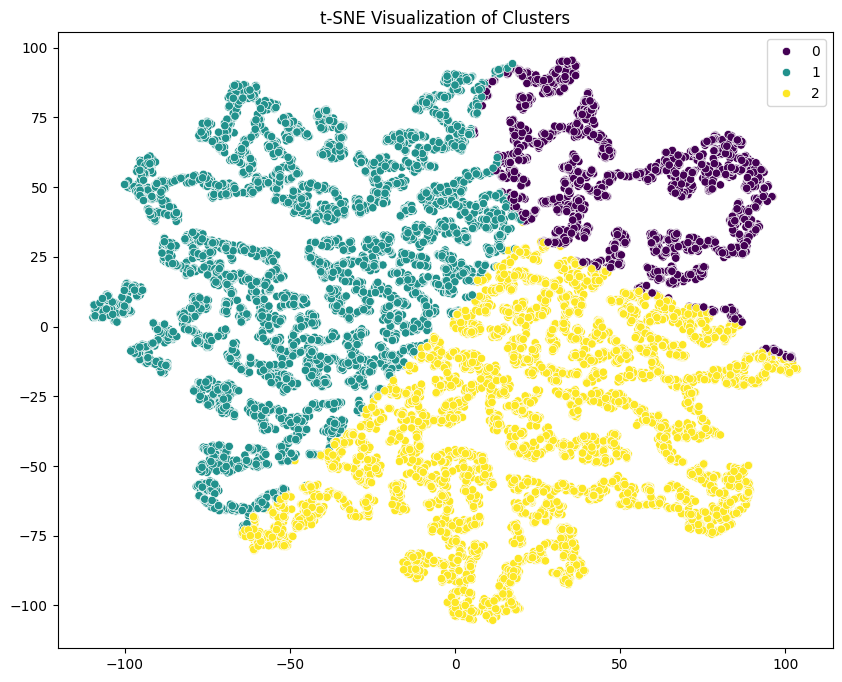

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize Clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Clusters')
plt.show()